# Load Everything Here

In [1]:
!pip install -U node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-cp37-none-any.whl size=5980 sha256=ac182d239649c38a84ebc044b2bae5d1d3def9b2f62285d6e2dc47de644bc2b6
  Stored in directory: /root/.cache/pip/wheels/34/f4/60/55708b5e797260310451d919c8f898bbd4acd1901367001f20
Successfully built node2vec


In [2]:
!pip install -U networkx

Requirement already up-to-date: networkx in /usr/local/lib/python3.7/dist-packages (2.5.1)


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
from node2vec import Node2Vec
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Read Data

In [4]:
df = pd.read_csv("Edgelist2020_2.csv")

In [5]:
df

,Source,Target,Weight
0,e1122,e6601,0.1273
1,e1122,e7800,0.1195
2,e1122,e785,0.2042
3,e1122,e8770,0.0730
4,e1122,i120,0.2158
...,...,...,...
30100,t2026xa,t2024xa,0.4846
30101,t2027xa,t20211a,0.4361
30102,t22231a,t22232a,0.5137
30103,s92324a,s92334a,0.8462


In [42]:
df[df.Source=="u071"].sort_values(by="Weight",ascending=False)

,Source,Target,Weight
18427,u071,j1289,0.7490
18433,u071,j9601,0.3978
18392,u071,e1165,0.1739
18426,u071,a4189,0.1605
18378,u071,e669,0.1360
...,...,...,...
18456,u071,i493,0.0114
18527,u071,a0839,0.0114
18530,u071,z886,0.0112
18514,u071,j811,0.0110


# Convert to Graph and Visualize

### graph conversion & info

In [10]:
%%time
graph=nx.convert_matrix.from_pandas_edgelist(df,source='Source', target='Target', edge_attr=True)
graph.name = "Covid DisNet for Edgelist2019_2"
print(nx.info(graph))
print("------------------------------------")

Name: Covid DisNet for Edgelist2019_2
Type: Graph
Number of nodes: 2101
Number of edges: 30105
Average degree:  28.6578
------------------------------------
CPU times: user 115 ms, sys: 2.87 ms, total: 118 ms
Wall time: 123 ms


### whole graph plot

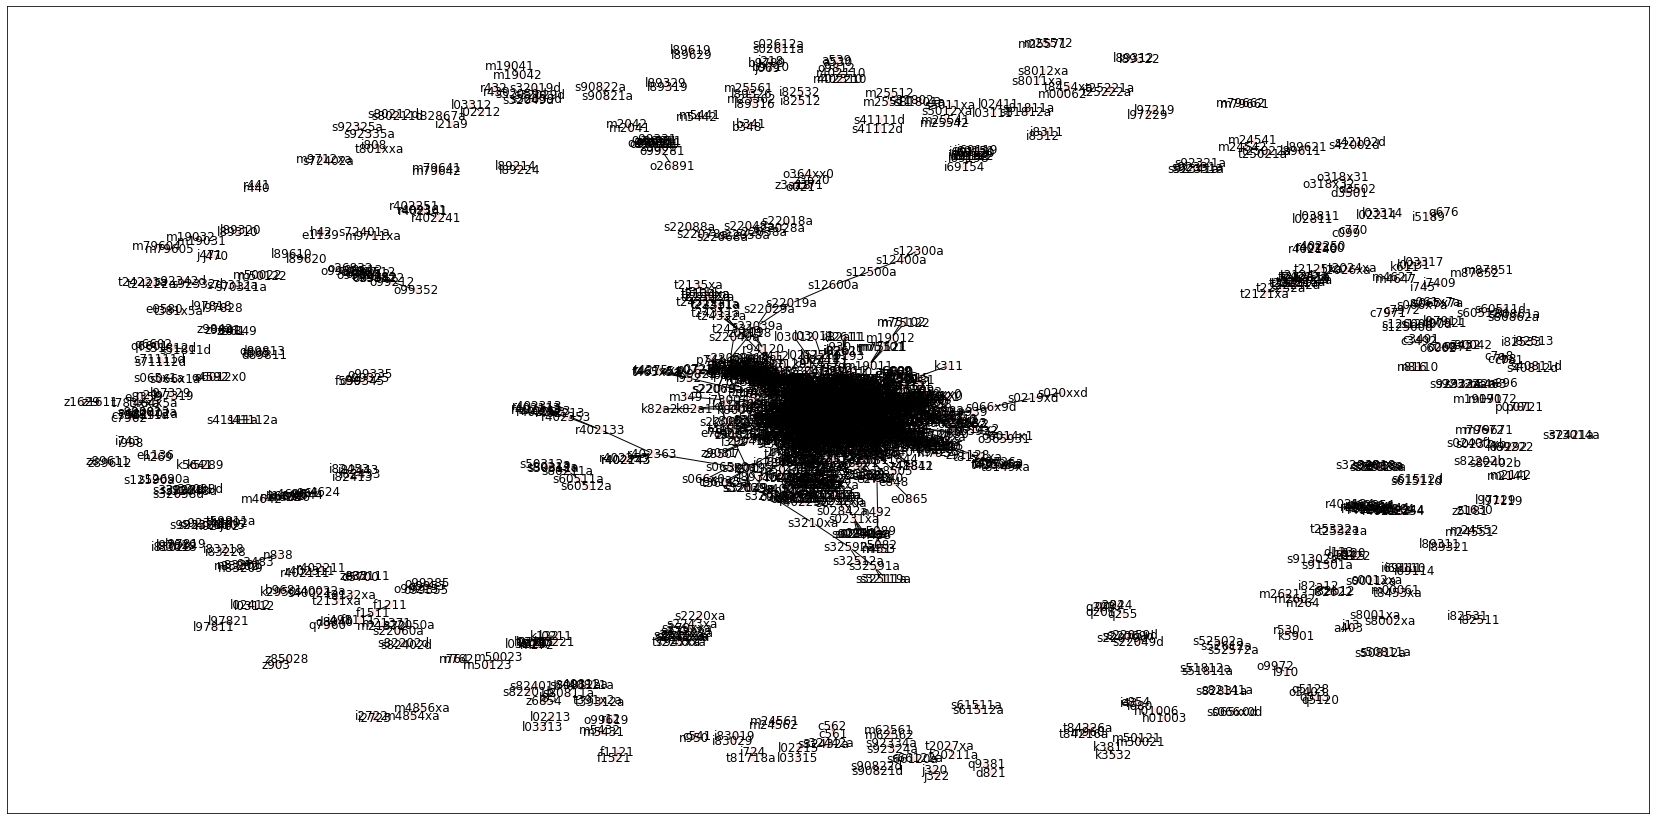

----------------------------------------
Density: 0.013646562861222547
----------------------------------------
CPU times: user 27.9 s, sys: 477 ms, total: 28.4 s
Wall time: 28.1 s


In [15]:
%%time
nx.draw_networkx(graph,
                 #pos,
                 with_labels=True,
                 node_size=30,
                 node_color="mistyrose",
                 #edgelist=edges, 
                 #edge_color=weights,
                 edge_cmap=plt.cm.Accent,
                 style="solid",
                 width=1)
nx.draw_networkx(graph.subgraph('z20828'),  font_size=16,node_size=120, node_color='red')
plt.subplots_adjust(left=1, bottom=3.2, right=4.8, top=6)
plt.show()

print("----------------------------------------")
print("Density:",nx.classes.function.density(graph))
print("----------------------------------------")

### partial graph plot

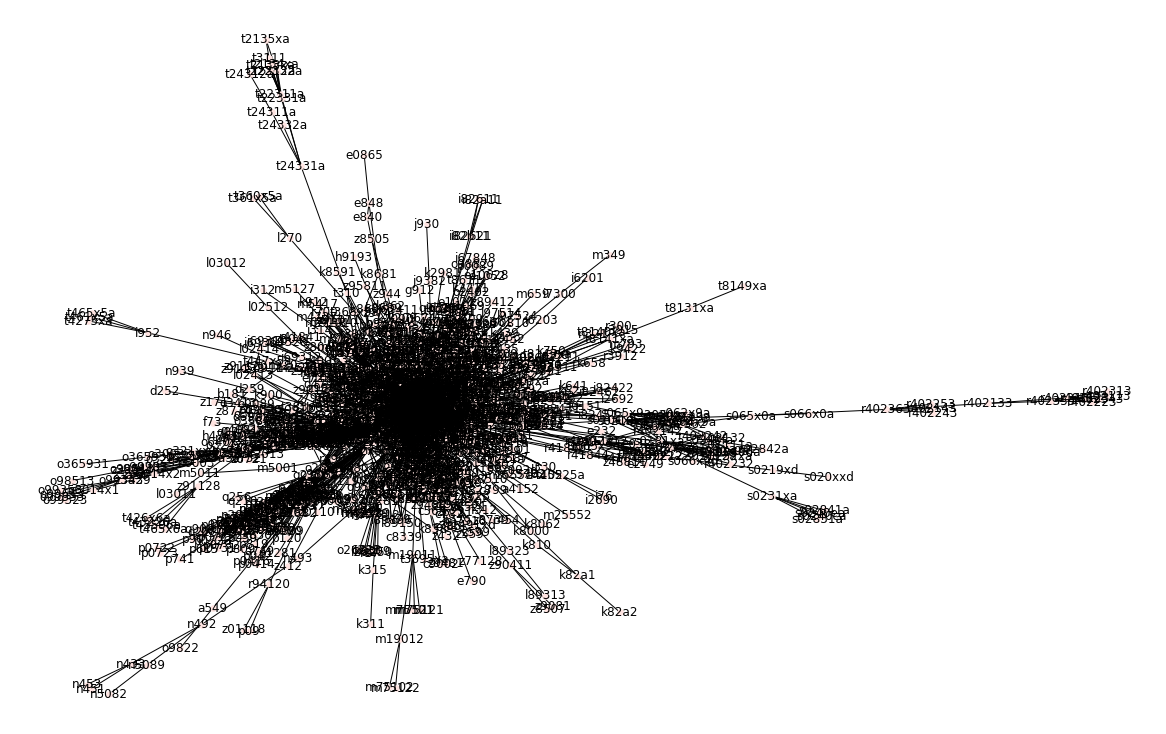

Density: 0.025556448085121437
----------------------------------------
CPU times: user 18.4 s, sys: 417 ms, total: 18.8 s
Wall time: 18.6 s


In [16]:
%%time
plt.figure(figsize=(16, 10))
gcc = max(nx.connected_components(graph), key=lambda x: len(x))
H = graph.subgraph(gcc)
nx.draw(H, node_size=30, node_color='mistyrose',with_labels=True,edge_cmap=plt.cm.Accent,style="solid",width=1)
plt.subplots_adjust(left=1, bottom=3.2, right=4.8, top=6)
plt.show()
print("Density:",nx.classes.function.density(H))
print("----------------------------------------")

### plot for z20828's neighbors

----------------------------------------
Density: 0.4957137645914397
----------------------------------------
CPU times: user 671 ms, sys: 136 ms, total: 808 ms
Wall time: 703 ms


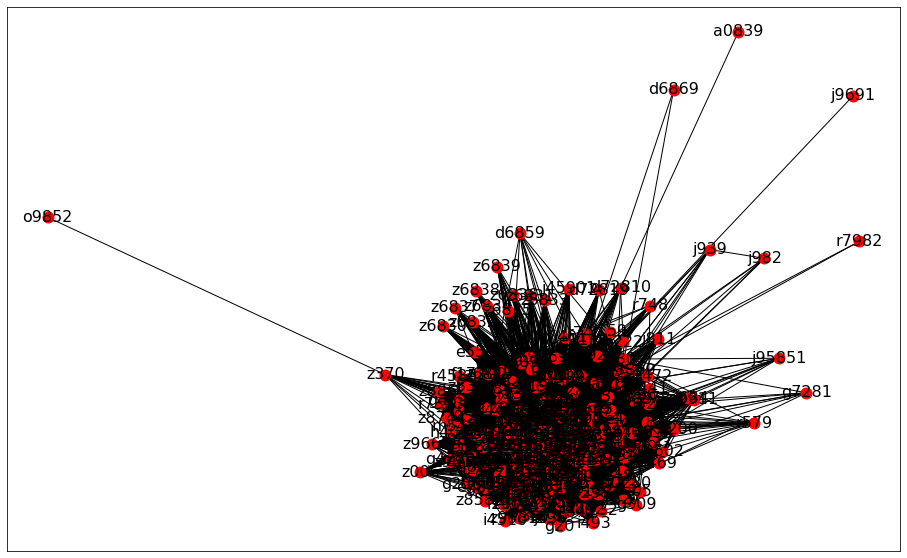

In [21]:
%%time
plt.figure(figsize=(16, 10))
Sub = nx.classes.function.induced_subgraph(graph,set(graph.neighbors(n="u071")))
nx.draw_networkx(Sub,  font_size=16,node_size=120, node_color='red')
print("----------------------------------------")
print("Density:",nx.classes.function.density(Sub))
print("----------------------------------------")

# Fit node2vec

In [23]:
vector_size = round(df.shape[0]**0.25)
vector_size

13

In [24]:
%%time
setup = Node2Vec(graph,dimensions=vector_size, walk_length=5, num_walks=5)
model = setup.fit(window=10, min_count=1)
print("--------------------------------------")

Generating walks (CPU: 1):   0%|          | 0/5 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


--------------------------------------
CPU times: user 45.1 s, sys: 291 ms, total: 45.4 s
Wall time: 45.5 s


In [25]:
%%time
#vocab, vectors = model.wv.key_to_index, model.wv.get_normed_vectors()
vocab, vectors = model.wv.vocab, model.wv.vectors

# get node name and embedding vector index.
name_index = np.array([(v[0], v[1].index) for v in vocab.items()]) #.index

# init dataframe using embedding vectors and set index as node name
node2vec_output = pd.DataFrame(vectors[name_index[:,1].astype(int)])
node2vec_output.index = name_index[:,0]

CPU times: user 9.14 ms, sys: 0 ns, total: 9.14 ms
Wall time: 9.53 ms


In [26]:
node2vec_output.shape

(2101, 13)

In [27]:
model.wv.most_similar("u071",topn=10)

[('j1289', 0.9987958669662476),
 ('z7902', 0.9977110028266907),
 ('z8673', 0.9975605010986328),
 ('e1165', 0.9971433281898499),
 ('d62', 0.9968411326408386),
 ('z86718', 0.996749997138977),
 ('g4733', 0.9966889023780823),
 ('f17210', 0.9966782331466675),
 ('j449', 0.9966689348220825),
 ('i129', 0.9966253042221069)]

# K-means

## Find k

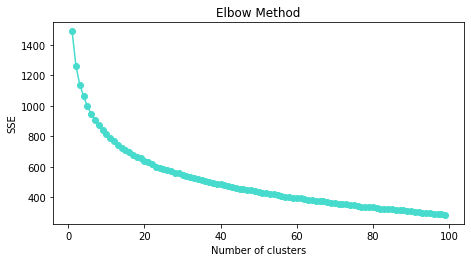

CPU times: user 7min 42s, sys: 6min 4s, total: 13min 47s
Wall time: 7min 19s


In [ ]:
%%time
SSE = []
for i in range(1,100):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=50, random_state=42)
    kmeans.fit(node2vec_output)
    SSE.append(kmeans.inertia_)
plt.plot(range(1,100), SSE,"o-",color="#47DBCD")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.subplots_adjust(left=0.25, bottom=0.8, right=1.2, top=1.5)
plt.show()

## plot k-means clustering

In [ ]:
n_clusters=kmeans.n_iter_

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=50, random_state=42)

In [ ]:
kmeans.fit(node2vec_output)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=12, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

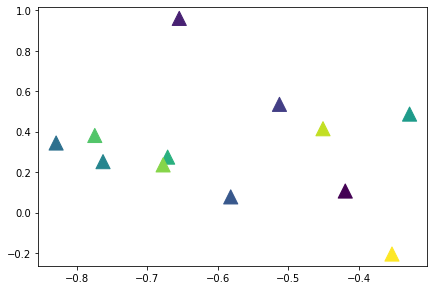

In [ ]:
t = np.arange(n_clusters)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=200, c=t,marker="^")
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=1)

In [ ]:
subsample=[]
for i in range(kmeans.n_clusters):
  temp = []
  temp=node2vec_output.iloc[kmeans.labels_==i,:]
  subsample.append(temp)

In [ ]:
for list in range(len(subsample)):
  print("Group",list+1)
  print(subsample[list])
  print("--------------------------------------------------------------")

Group 1
               0         1         2   ...        10        11        12
i712    -0.316004  0.096412  0.057411  ... -0.258166 -0.219993  0.396013
z91011  -0.375673  0.108014  0.035622  ... -0.311963 -0.281591  0.444286
z91018  -0.479282  0.048399  0.109698  ... -0.375803 -0.438254  0.626932
f1190   -0.378115  0.107304  0.149873  ... -0.316491 -0.326526  0.496876
t8383xa -0.353771  0.029830  0.075652  ... -0.238590 -0.293658  0.407575
...           ...       ...       ...  ...       ...       ...       ...
b009    -0.359220  0.140486  0.139076  ... -0.269510 -0.266727  0.424972
a414    -0.304050  0.030003  0.036535  ... -0.284032 -0.287612  0.435085
f4321   -0.357087  0.080699  0.090113  ... -0.240424 -0.230318  0.443794
f72     -0.634551  0.180543  0.043058  ... -0.435499 -0.332613  0.526848
e1042   -0.355281  0.307304  0.049246  ... -0.451315 -0.360015  0.483274

[972 rows x 13 columns]
--------------------------------------------------------------
Group 2
             0      

# T-SNE

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=10, init='random', n_iter=5000, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(32, 20))
    sns.scatterplot(
        x=x, y=y,
        hue= kmeans.labels_,
        palette=sns.color_palette("hls", len(set(kmeans.labels_))),
        legend="full",
        alpha=0.7,
        s=120
        ) 
    for i in range(len(x)):
      
      plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(3, 1),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    
        
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


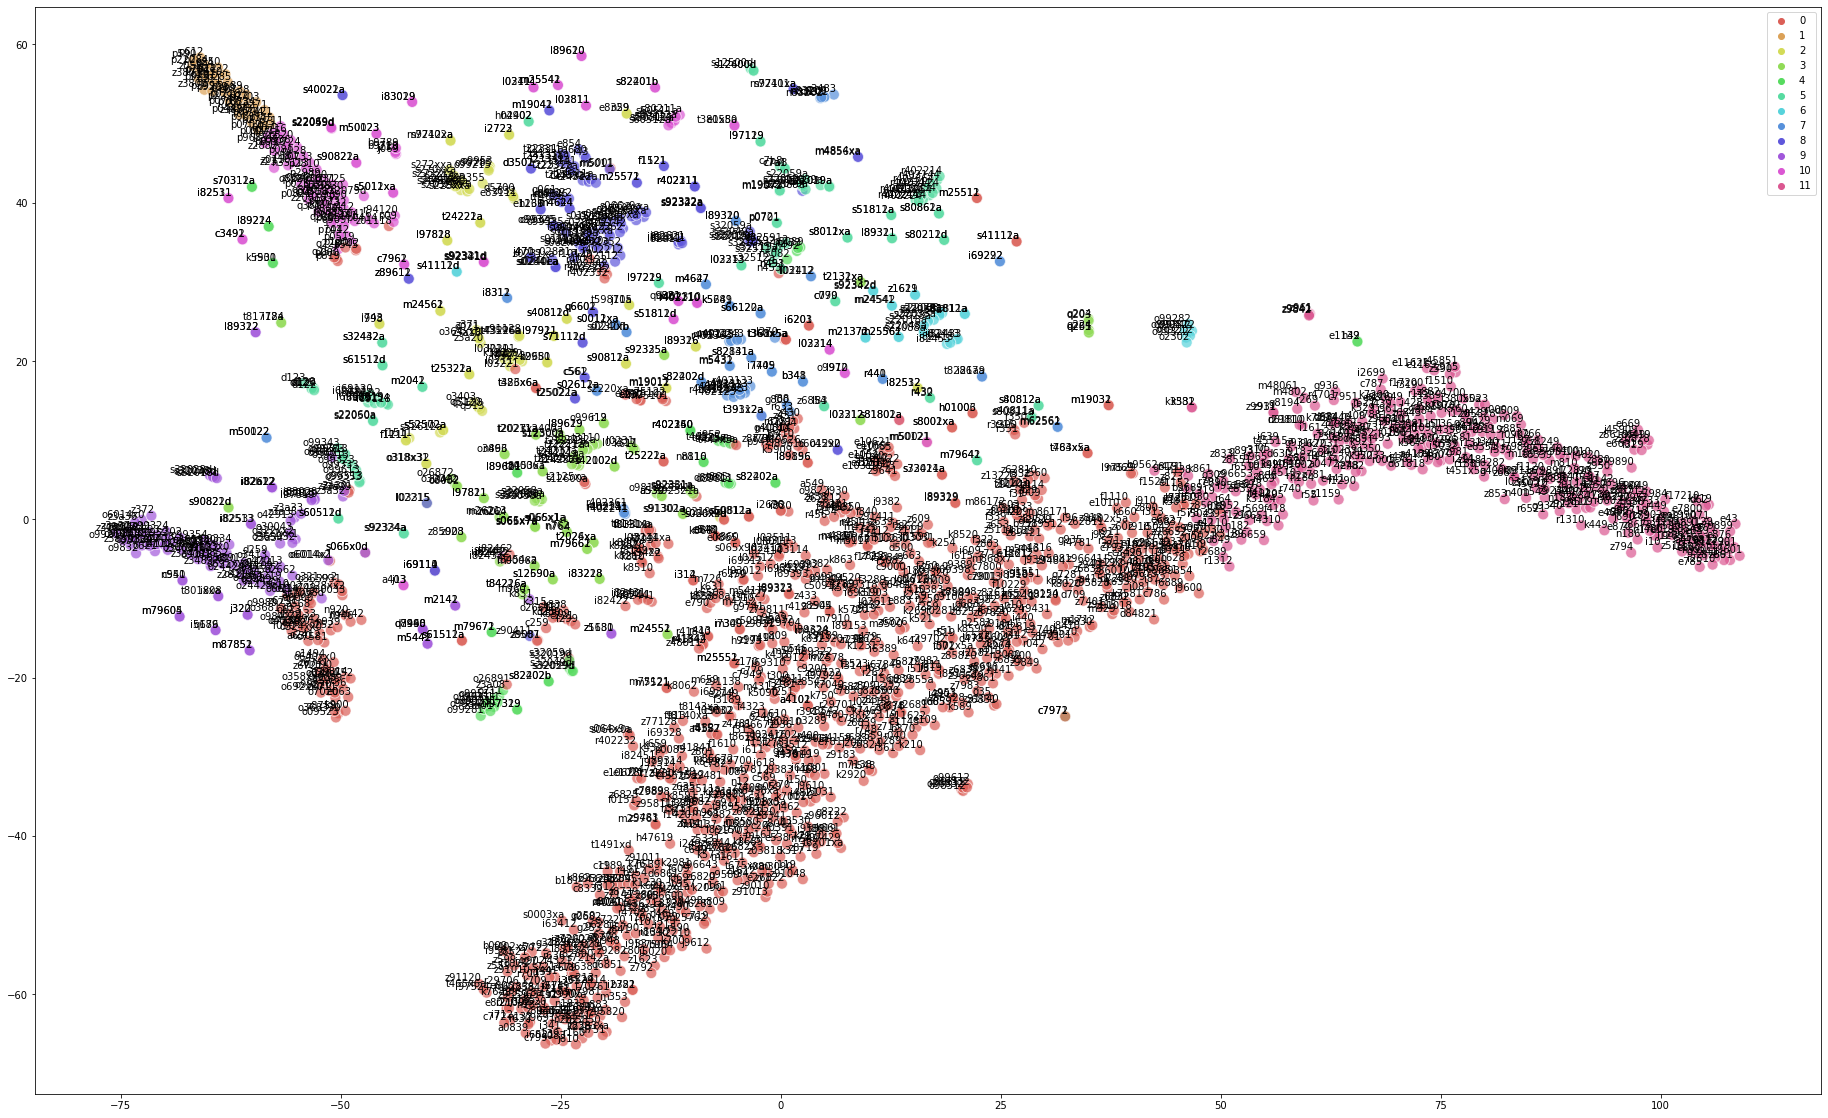

CPU times: user 2min 51s, sys: 1.39 s, total: 2min 52s
Wall time: 1min 32s


In [ ]:
%%time
tsne_plot(model)